# Notes on Superhydrophobic Nanopartical Coatings Solar Panel Processing Code and Analysis

The goal of this project put forth by Dr. Amanda Barker at CRREL is to inform the Army of the performace and applicability of commercially-available solar panel coatings. We are looking to study the main effects of these coatings. We suppose that the coatings minimize the effect of ice, dirt, and most importantly snow accumulation during extreme weather events, in turn we hope the panels will perform better and be easier to maintain over their lifetime.

## Methods
This project tested 3 different solar panel coatings. Coating 1 was described as a 'proprietary compound'. Coating 2 is a silicon dioxide nanoparticle-based proprietary substance. Coating 3 is a titanium dioxide nanoparticle-base proprietary substance. Site information such as angle of array, solar irradiance, albedo, global horizontal irradiance, air temperature, panel temperature, daily time-lapse video, and wind velocity were also obtained. 
...


## Time-lapse Processing Code

#### Introduction 
We expect snow cover to be a key predictor in the performance of each panel. To measure snow cover daily time-lapse videos were recorded. In the processing of this data there are some key factors to keep in mind. The time series time step of the data is important, we want to be able to capture the signal that is snow cover while at the same time ensuring that our analysis adequately deals with the possibility of autocorrelation in our data. 

#### Dependencies 
For a majority of this project we will be using python, and more specifically cv2 the python wrapper for OpenCV. 

In [2]:
import numpy as np
import pandas as pd
import os 
from PIL import Image
import cv2 # For Image Processing 
from matplotlib import pyplot as plt
import copy
import pytesseract

pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"


In [3]:
            #### Code for frame processing. 
                # Crop the image into separate. 
                    # Either all panels or separate the panels as well.
                # Binarize the image with otsu
                # Snowcover is fraction of white pixels 
                # Pull timestamp from frame
                # Add new data to Pandas Datafame.

# https://www.geeksforgeeks.org/text-detection-and-extraction-using-opencv-and-ocr/ for pulling timestamp

def ImageProcess(img, Mask):
    im2 = img.copy()
    # Preprocessing the image starts here
    # Convert the image to gray scale
	# Add border 
	# RESIZE
	# Add Blur
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    TimeStampCrop = gray[0:70,0:874]
    TimeStampCrop = cv2.copyMakeBorder(TimeStampCrop, 40, 40, 40, 40, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    TimeStampCrop = cv2.resize(TimeStampCrop, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_CUBIC)
    cv2.threshold(cv2.medianBlur(TimeStampCrop, 3), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

	
    TimeStampText = pytesseract.image_to_string(TimeStampCrop)
    global SnowCover
    Test = pd.DataFrame([[TimeStampText, 3]], columns = ['TimeStamp', 'SnowCover'])
    SnowCover = pd.concat([SnowCover,Test], ignore_index=True)
    plt.imshow(TimeStampCrop)

    

   ## # Applying the threshold
   ## threshImage = copy.deepcopy(img)
   ## ret, thresh = cv2.threshold(threshImage,0,255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
   ## 
   ## # Creating the masks
   ## mask_fore = copy.deepcopy(img)
   ## mask_fore = np.where((img).astype(np.uint8) > ret, 0, 255)  
   ## image_fore = Image.fromarray((mask_fore).astype(np.uint8))
   ## os.chdir(str(path+'/Foreground_Masks'))
   ## image_fore.save(str(i),"JPEG") 


# importing the module
MaskCoordinates = []

# function to display the coordinates of
# of the points clicked on the image
def click_event(event, x, y, flags, params):
	global MaskCoordinates
	# checking for left mouse clicks
	if event == cv2.EVENT_LBUTTONDOWN:

		# displaying the coordinates
		# on the Shell
		print(x, ' ', y)
		MaskCoordinates.append((x, y))

		# displaying the coordinates
		# on the image window
		font = cv2.FONT_HERSHEY_SIMPLEX
		cv2.putText(img, str(x) + ',' +
					str(y), (x,y), font,
					1, (255, 0, 0), 2)
		cv2.imshow('image', img)

	# checking for right mouse clicks	
	if event==cv2.EVENT_RBUTTONDOWN:

		# displaying the coordinates
		# on the Shell
		print(x, ' ', y)
		MaskCoordinates.append((x, y))


		# displaying the coordinates
		# on the image window
		font = cv2.FONT_HERSHEY_SIMPLEX
		b = img[y, x, 0]
		g = img[y, x, 1]
		r = img[y, x, 2]
		cv2.putText(img, str(b) + ',' +
					str(g) + ',' + str(r),
					(x,y), font, 1,
					(255, 255, 0), 2)
		cv2.imshow('image', img)

# Driver and generate masks function, takes a cv2 image object. 
# We will set this to take the first image from every timelapse. 
def generateMasks(img):

	# displaying the image
	cv2.imshow('image', img)

	# setting mouse handler for the image
	# and calling the click_event() function
	cv2.setMouseCallback('image', click_event)

	# wait for a key to be pressed to exit
	cv2.waitKey(0)

	# close the window
	cv2.destroyAllWindows()




766   573


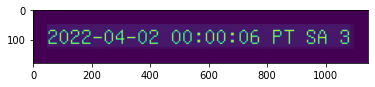

In [4]:
#### Full Script For Segmentation and SnowCover Data Extraction 
SnowCover = pd.DataFrame(columns = ['TimeStamp', 'SnowCover'])

#path = "/Users/stefanofochesatto/Desktop/CRREL-Solar-Project/TestTimeLapse" ##Supply Full Path to TimeLapse directory

path = r"C:\Users\Amanda Barker\Desktop\Stefano\CRREL-Solar-Project\TestTimeLapse"

#### Directory Management
os.chdir(path) #Change the working directory to the TimeLapse directory

TimeLapseList = [] #Pull the current list of files in TimeLapse directory
for file in os.listdir(path):
    if file.endswith(".mp4"): 
        TimeLapseList.append(file)


for i in TimeLapseList:
    os.chdir(path) # We have to set the path everytime since cv2 can't handle relative paths without it.
    currentVideo = cv2.VideoCapture(i, cv2.IMREAD_GRAYSCALE) # Reading in the current TimeLapse Video
    success, img = currentVideo.read()
    fno = 0
    #Get Points to generate mask for each recording. 
    sample_rate = 1
    Mask = generateMasks(img)
    while success:
        if fno % sample_rate == 0:
            ImageProcess(img, Mask)
        # read next frame
        success, img = currentVideo.read()

## Resetting mask coordinates list
global MaskCoordinates
MaskCoordinates = []


In [5]:

## Preliminary Image Processing Code
path = r'C:\Users\Amanda Barker\Desktop\Stefano\CRREL Solar Panel Project\TestTimeLapse' ##Supply Full Path to TimeLapse directory
os.chdir(path) # We have to set the path everytime since cv2 can't handle relative paths without it.
img = cv2.imread('TestImage2.png') # Reading in the current image
plt.imshow(img)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(thresh)
contours, hiers = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) # [-2:] indexing takes return value before last (due to OpenCV compatibility issues).
image_copy = img.copy()
cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

plt.imshow(image_copy)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\Amanda Barker\\Desktop\\Stefano\\CRREL Solar Panel Project\\TestTimeLapse'

In [12]:
print(MaskCoordinates)
global MaskCoordinates
MaskCoordinates = []

[]


In [7]:
print(SnowCover['TimeStamp'])

0      eQee-O04-01 22:55:06 PT SA 3\n
1     eQe2e-O04-01 22:56:06 PT SA 3\n
2     eQe2e-O04-01 22:57:06 PT SA 3\n
3      eQee-O04-01 22:56:06 PT SA 3\n
4      eQee-O04-01 22:59:06 PT SA 3\n
                   ...               
61     eQee-O04-01 25:56:07 PT SA 3\n
62      eQee-O4-01 25:57:06 PT SA 3\n
63      eQee-04-01 25:56:06 PT SA 3\n
64     eQe2e-04-01 25:59:06 PT SA 3\n
65      eQee-04-02 OO:00:06 PT SA 3\n
Name: TimeStamp, Length: 66, dtype: object


In [5]:
global SnowCover
SnowCover = pd.DataFrame(columns = ['TimeStamp', 'SnowCover'])
Test = pd.DataFrame([['TimeStampText', 3]], columns = ['TimeStamp', 'SnowCover'])
SnowCover = pd.concat([SnowCover,Test], ignore_index=True)
print(SnowCover)

       TimeStamp SnowCover
0  TimeStampText         3


eOe2-O4-O01 OF8:4d4di17 PT SA 1



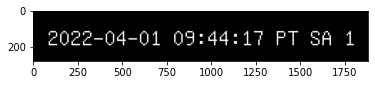

In [10]:
img = cv2.imread('TestImage2.png')
# Preprocessing the image starts here
# Convert the image to gray scale
# Add border 
# RESIZE
# Add Blur

TimeStampCrop = img[0:60,0:860]
#TimeStampCrop = img[0:60,0:320]
#RESIZE
TimeStampCrop = cv2.resize(TimeStampCrop, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

TimeStampCrop = cv2.copyMakeBorder(TimeStampCrop, 80, 80, 80, 80, cv2.BORDER_CONSTANT, value=[0, 0, 0])
#GRAYSCALE
TimeStampCrop = cv2.cvtColor(TimeStampCrop, cv2.COLOR_BGR2GRAY)
#Dilation and Erosion
kernel = np.ones((1, 1), np.uint8)
TimeStampCrop = cv2.dilate(TimeStampCrop, kernel, iterations=10)
TimeStampCrop = cv2.erode(TimeStampCrop, kernel, iterations=1)
#Applying Blur
TimeStampCrop = cv2.threshold(cv2.medianBlur(TimeStampCrop, 1), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]








plt.imshow(TimeStampCrop, cmap = 'gray')

TimeStampText = pytesseract.image_to_string(TimeStampCrop)
print(TimeStampText)
global SnowCover
Test = pd.DataFrame([[TimeStampText, 3]], columns = ['TimeStamp', 'SnowCover'])
SnowCover = pd.concat([SnowCover,Test], ignore_index=True)






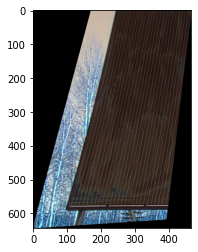

In [32]:
img = cv2.imread('TestImage2.png') # Reading in the current image

pts = np.array([(314,162),(142,804),(535,778),(608,165)])
## (1) Crop the bounding rect
rect = cv2.boundingRect(pts)
x,y,w,h = rect
croped = img[y:y+h, x:x+w].copy()

## (2) make mask
pts = pts - pts.min(axis=0)

mask = np.zeros(croped.shape[:2], np.uint8)
cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

## (3) do bit-op
dst = cv2.bitwise_and(croped, croped, mask=mask)

## (4) add the white background
bg = np.ones_like(croped, np.uint8)*255
cv2.bitwise_not(bg,bg, mask=mask)
dst2 = bg+ dst




plt.imshow(dst)


In [33]:
for i in range(0,16,4):
    print(i)

0
4
8
12


In [29]:
SnowCover = pd.DataFrame(columns = ['TimeStamp', 'SnowCover'])

In [7]:
import easyocr

In [11]:
reader = easyocr.Reader(['en'])
Text = reader.readtext(TimeStampCrop)
print(Text[1])

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


([[775, 97], [1299, 97], [1299, 205], [775, 205]], '09:44:17', 0.8330024519655548)


In [21]:
print([val[1] for val in Text])

['2022-04-01', '09:44:17', 'PT', 'SA', '1']
